#Install required modules

In [2]:
pip install -r requirements.txt

  Using cached scikit_fuzzy-0.4.2-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 21.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 21.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 22.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.0/245.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 21.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━

#Import required modules

In [93]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz
from copy import deepcopy
import json
import numpy as np
from scipy.linalg import fractional_matrix_power
import matplotlib.pyplot as plt
import pickle

In [94]:
path = '/Users/ashfak/Downloads/rerequestforcode'
#app = 'bearboard'
#app = 'upacharpharmacy'
#app = 'book'
app = 'trainticket'
# app = 'book_no_extra'
if(app == 'bearboard'):
  entrypoints_texts = ['GreetingController', 'AwardController', 'UserController', 'TweetController', 'EventController','WhitelistUserController']
elif(app == 'upacharpharmacy'):
  entrypoints_texts = ['DataController', 'OrderController','CategoryController', 'DrugController','UserController','DosageFormController','SubCategoryController']
elif(app == 'autocarenepal'):
  entrypoints_texts = ['SystemController', 'VehicleController','UserController','CommentController']
elif(app == 'book'):
  entrypoints_texts = ['TicketController', 'OrderController', 'RestaurantController', 'ConsumerController', 'CourierController']
elif(app == 'book_no_extra'):
  entrypoints_texts = ['OrderController', 'RestaurantController', 'ConsumerController']
elif(app == 'trainticket'):
  f = open(path + f'/{app}_entrypoint.txt')
  data = f.read().strip()
  entrypoints_texts = data.split('\n')

# Data Preprocessing

In [108]:
dep_file = open(path + '/' + app + '_dependency.json', 'r')
string_data = dep_file.read()
dep_file.close()
json_data = json.loads(string_data)

In [109]:
not_keys = []
for key, vals in json_data.items():
  for cls in vals:
    if(cls not in json_data.keys() and cls not in not_keys):
      not_keys.append(cls)
for key in not_keys:
  json_data[key] = []

In [110]:
cur_inx = 0
classToNode = {}
nodeToClass = {}
for class_ in json_data.keys():
  nodeToClass[cur_inx] = class_
  classToNode[class_] = cur_inx
  cur_inx += 1

In [111]:
n_nodes = len(json_data)
entrypoints = []
for entrypoint in entrypoints_texts:
  entrypoints.append(classToNode[entrypoint])
A = np.zeros((n_nodes,n_nodes))
for key, lst in json_data.items():
  for class_ in lst:
    A[classToNode[key], classToNode[class_]] = 1
C = np.zeros((n_nodes,n_nodes))
E = np.zeros((n_nodes,len(entrypoints)))
paths = []
def dfs_for_E(node, visited, graph, entrypoint_inx):
  if(visited[node] == 1):
    return
  visited[node] = 1
  for i in range(graph.shape[1]):
    if(graph[node,i] == 1):
      if(E[i, entrypoint_inx] == 0):
        E[i, entrypoint_inx] = 1
      dfs_for_E(i, visited,graph, entrypoint_inx)

def dfs_for_paths(node, visited, graph, entrypoint_inx, cur_path):
  #if(visited[node] == 1):
  if(node in cur_path):
    paths[entrypoint_inx].append(cur_path)
    return
  tmp_path = deepcopy(cur_path)
  tmp_path.append(node)
  #visited[node] = 1
  if(np.sum(graph[node]) == 0):
    paths[entrypoint_inx].append(tmp_path)
    return
  for i in range(graph.shape[1]):
    if(graph[node,i] == 1):
      dfs_for_paths(i, visited,graph, entrypoint_inx, tmp_path)

def getEntrypointMatrix(adj_graph, entrypoints):
  for inx, entrypoint in enumerate(entrypoints):
    visited = np.zeros(n_nodes)
    dfs_for_E(entrypoint, visited, adj_graph, inx)

def getNoOfCoEntrypoints(node1, node2, paths, entrypoints):
  for i in range(len(entrypoints)):
    for path in paths[i]:
      if(node1 in path and node2 in path):
        if(node1 != node2):
          C[node1, node2] += 1
          C[node2, node1] += 1
        else:
          C[node1, node2] += 1
def getCoEntrypointMatrix(adj_graph, entrypoints):
  global paths
  paths = [[] for _ in range(len(entrypoints))]
  for i in range(len(entrypoints)):
    visited = np.zeros(n_nodes)
    dfs_for_paths(entrypoints[i], visited, adj_graph, i, [])
  for i in range(n_nodes):
    for j in range(n_nodes):
      getNoOfCoEntrypoints(i,j,paths, entrypoints)


In [112]:
getEntrypointMatrix(A, entrypoints)
getCoEntrypointMatrix(A, entrypoints)
for i in range(n_nodes):
  A[i,i] = 1
D = np.zeros((n_nodes, n_nodes))
for i in range(n_nodes):
  for j in range(n_nodes):
    D[i,i] += A[i,j]
print(D)
D_half_norm = fractional_matrix_power(D, -0.5)
X = np.concatenate((E,C), axis=1)
print(X)
X = D_half_norm.dot(A).dot(D_half_norm).dot(X)



[[1. 0. 0. ... 0. 0. 0.]
 [0. 4. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#Define variational autoencoder

In [113]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, A, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.A = A
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.architecture_loss_tracker = keras.metrics.Mean(
            name="architecture_loss"
        )

    def call(self, inputs):
      mean, log_var, x = self.encoder(inputs)
      x = self.decoder(x)
      return x

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.architecture_loss_tracker
        ]
    def predict(self, data):
       z_mean, z_log_var, z = self.encoder(data)
       output = self.decoder(z)
       return output

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #reconstruction_loss = tf.reduce_mean(
            #    tf.reduce_sum(
            #        keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)
            #    )
            #)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data-reconstruction), axis=(1)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            architecture_loss = tf.reduce_mean(tf.square(self.A - tf.matmul(z,z,transpose_b=True)))
            total_loss = reconstruction_loss + kl_loss + architecture_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.architecture_loss_tracker.update_state(architecture_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "architecture_loss": self.architecture_loss_tracker.result()
        }

#Define hyperparameters

In [114]:
#For VAE
nFeatures = X.shape[1]
nEmbeddings = 2
nEpochs = 8000
learningRate = 0.001
optimizer = Adam(learningRate)
batchSize = X.shape[0]


#Obtain and preprocess data

In [115]:
scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

#Define VAE's architecture

In [116]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

print(nFeatures)
input_encoder = Input(shape=(nFeatures, ))
nNeurons = nFeatures // 2
x = Dense(nNeurons, activation='tanh')(input_encoder)
nNeurons = nNeurons // 2
while(nNeurons >= nEmbeddings * 2):
  x = Dense(nNeurons, activation='tanh')(x)
  nNeurons = nNeurons // 2
z_mean = Dense(nEmbeddings, name="z_mean")(x)
z_log_var = Dense(nEmbeddings, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

input_decoder = Input(shape=(nEmbeddings, ))
nNeurons = nEmbeddings * 2
x = Dense(nNeurons, activation='tanh')(input_decoder)
nNeurons = nNeurons * 2
while(nNeurons <= nFeatures // 2):
  x = Dense(nNeurons, activation='tanh')(x)
  nNeurons = nNeurons * 2
recon = Dense(nFeatures)(x)
encoder = Model(input_encoder, [z_mean, z_log_var, z], name="encoder")
decoder = Model(input_decoder, recon, name="decoder")
vae = VAE(encoder, decoder, A)
vae.compile(optimizer=optimizer)
vae.built = True

331


In [117]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 331)            │        42,699 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,871 (210.43 KB)

 Trainable params: 53,871 (210.43 KB)

 Non-trainable params: 0 (0.00 B)

#Train VAE

In [118]:
vae.encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 331)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 165)       │     54,780 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 82)        │     13,612 │ dense_43[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 41)        │      3,403 │ dense_44[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 20)        │        840 │ dense_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 10)        │        210 │ dense_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 5)         │         55 │ dense_47[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         12 │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         12 │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_5          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 72,924 (284.86 KB)

 Trainable params: 72,924 (284.86 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
hist = vae.fit(X, epochs = nEpochs, batch_size=batchSize, verbose =False)

In [120]:
vae.save_weights(path + '/vae_' + app+'vae_' + '.weights.h5')

In [121]:
vae.load_weights(path + '/vae_' + app+'vae_' + '.weights.h5')

dict_keys(['architecture_loss', 'kl_loss', 'reconstruction_loss', 'total_loss'])


Text(0, 0.5, 'Architecture loss')

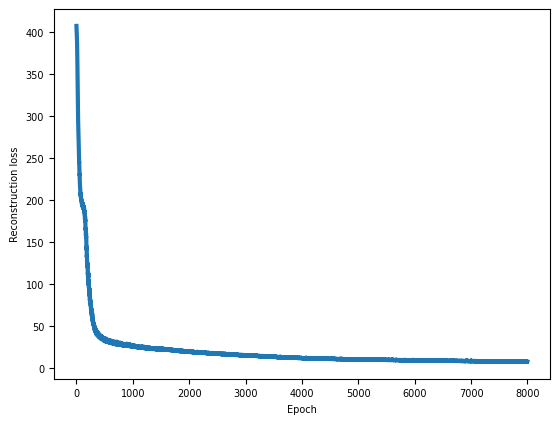

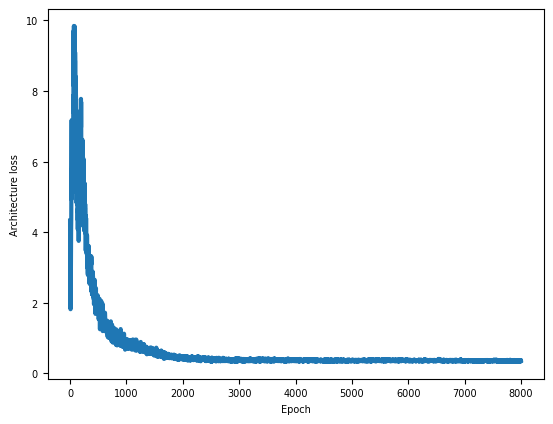

In [122]:
print(hist.history.keys())
x_range = range(len(hist.history['reconstruction_loss']))
plt.plot(x_range, hist.history['reconstruction_loss'])
plt.xlabel('Epoch')
plt.ylabel('Reconstruction loss')
plt.figure()
plt.plot(x_range, hist.history['architecture_loss'])
plt.xlabel('Epoch')
plt.ylabel('Architecture loss')

In [123]:
_,_,Z = vae.encoder(X)


#Apply C-Means

In [125]:
from sklearn.metrics import silhouette_score

In [126]:
maxNCenters = 100
m = 10
losses = []
memberships = []
centroids = []
silhouette_scores = []
for nCenters in range(2,maxNCenters+1):
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
          Z.numpy().T, nCenters, m, error=0.005, maxiter=1000, init=None)
  memberships.append(u)
  centroids.append(cntr)
  sse = 0
  for i in range(len(Z)):
    zLoc = np.asarray(Z[i])
    for j in range(nCenters):
      cLoc = np.asarray(cntr[j])
      sse += u[j][i] * np.sum(np.square(zLoc - cLoc))
  losses.append(sse)
  hard_clusters = np.argmax(u, axis=0)
  silhouette_scores.append(silhouette_score(Z, hard_clusters))  
#losses.append(np.mean(np.square(d)))
with open(path + '/memberships/' + app + f'_m={m}.pkl','wb') as f:
  pickle.dump([memberships, centroids], f)

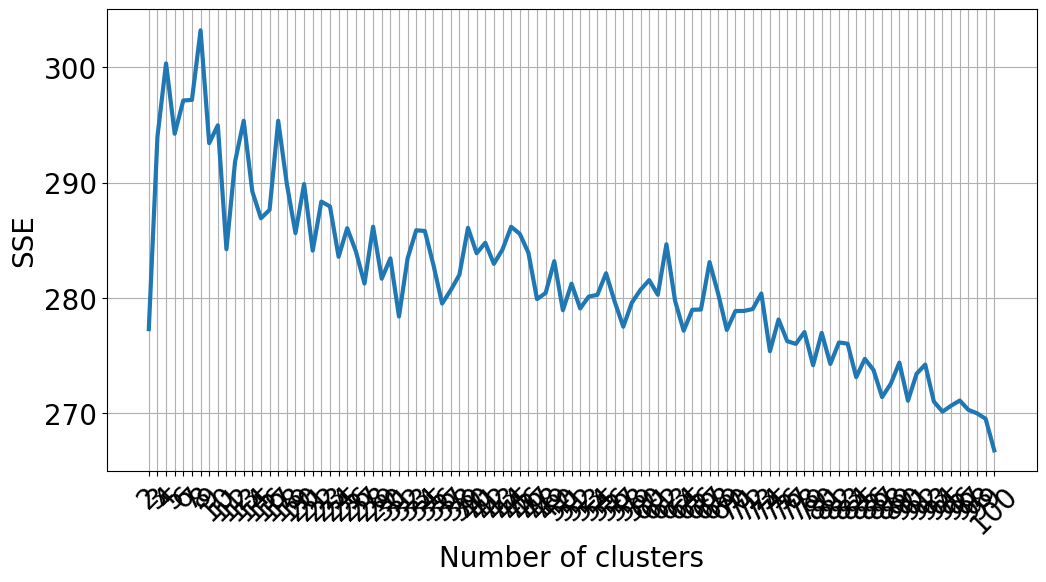

In [129]:
x_range = [i for i in range(2,maxNCenters+1)]
plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 20, 'lines.linewidth':3})
plt.plot(x_range,losses)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.xticks(x_range, rotation=45)
plt.grid(True)
plt.savefig(path + '/figures/' + app + f'_sse_cmeans_m={m}.png', dpi=450, bbox_inches = "tight")

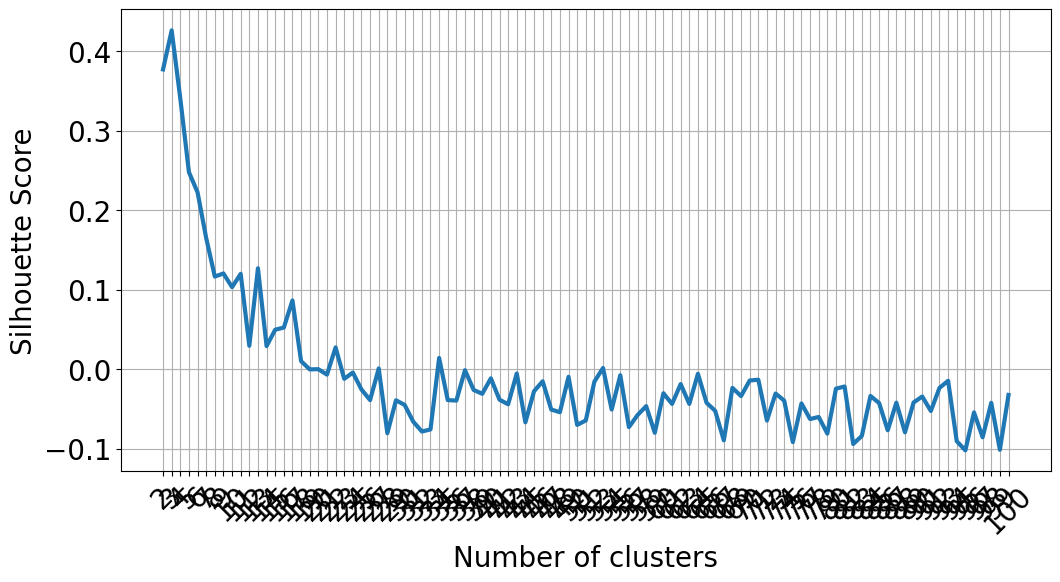

In [130]:
x_range = [i for i in range(2,maxNCenters+1)]
plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 20, 'lines.linewidth':3})
plt.plot(x_range,silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(x_range, rotation=45)
plt.grid(True)

In [133]:
n_clusters = 20
members = [[] for i in range(n_clusters)]
members_classes = [[] for i in range(n_clusters)]
clusters = np.argmax(memberships[n_clusters-2].T, axis = 1)
for i in range(len(clusters)):
  members[clusters[i]].append(i)
  members_classes[clusters[i]].append(nodeToClass[i])

In [134]:
file = open(path + '/list_microservices/'+app+'_'+ str(n_clusters) + f'_no_redundancy_m={m}.json','w')
file.write(json.dumps(members_classes))
file.close()

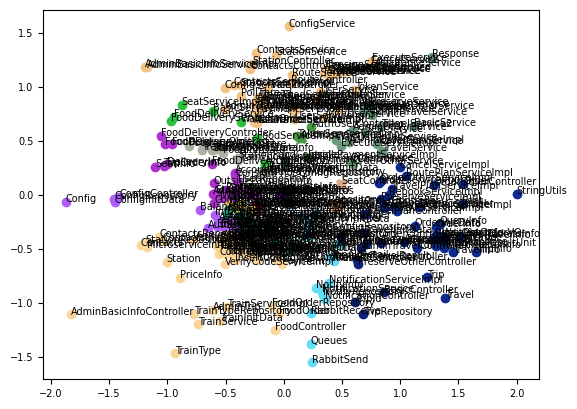

In [135]:
import random
y = [[] for i in range(n_clusters)]
x = [[] for i in range(n_clusters)]
centroid_y = []
centroid_x = []
hexadecimal_alphabets = '0123456789ABCDEF'
colors = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(n_clusters)]
# colors = ['red','green','blue','purple','orange', 'black', 'gray', 'pink', 'yellow', 'navy']
for i in range(n_clusters):
  for j in members[i]:
    y[i].append(Z[j][1])
    x[i].append(Z[j][0])
  centroid_y.append(centroids[n_clusters-2][i][1])
  centroid_x.append(centroids[n_clusters-2][i][0])
# plt.axis('off')
plt.rcParams.update({'font.size': 7, 'lines.linewidth':3})
for i in range(n_clusters):
  plt.scatter([centroid_x[i]], [centroid_y[i]], color=colors[i],marker='x')
  plt.scatter(x[i], y[i], color=colors[i])
  for j in range(len(x[i])):
    plt.text(x[i][j], y[i][j], members_classes[i][j])
plt.savefig(path +'/figures/' + app + '_' + str(n_clusters) + f'_scatter_no_redundancy_m={m}.pdf', dpi=450, bbox_inches = "tight")

In [89]:
thresholds = []
i = 0.1
while(i <= 0.5):
  thresholds.append(round(i,2))
  i += 0.05
set_members = []
for threshold in thresholds:
  tmp_members = deepcopy(members)
  tmp_members_classes = deepcopy(members_classes)
  for inx, membership in enumerate(memberships[n_clusters-2]):
    for inx2, score in enumerate(membership):
      if(score >=  threshold and inx2 not in tmp_members[inx]):
        tmp_members[inx].append(inx2)
        tmp_members_classes[inx].append(node_names_array[inx2])
  set_members.append(tmp_members_classes)
  file = open(path + '/list_microservices/'+app+'_' + str(n_clusters) + f'_redundancy_m={m}_' + str(threshold) + '.json','w')
  file.write(json.dumps(tmp_members_classes))
  file.close()

In [90]:
for lst in set_members[4]:
  print(len(lst))

7
7
4
3
1
2
1
1
6
1
1
7
2
1
1
2
2
1
9
3


In [91]:
for member in members:
  print(len(member))

7
7
4
3
1
2
1
1
6
1
1
7
2
1
1
2
2
1
9
3


In [92]:
print(memberships[0][0])

[0.47783662 0.48955833 0.45158945 0.52602976 0.38654769 0.51455682
 0.48946296 0.4714585  0.51413552 0.4838117  0.50577318 0.4469447
 0.52593318 0.53401749 0.4904927  0.55623568 0.52468325 0.51445527
 0.47166398 0.48294783 0.5387723  0.52723447 0.43351599 0.49733
 0.47687013 0.49095364 0.51701705 0.60089205 0.52334532 0.48629424
 0.45678408 0.48399028 0.474508   0.53053071 0.52516405 0.45014974
 0.48919129 0.51430144 0.50265809 0.52298731 0.47016148 0.54071268
 0.52216447 0.47429891 0.51333832 0.52112051 0.5281628  0.57673823
 0.48496643 0.5516904  0.4829871  0.51434327 0.51134393 0.46922726
 0.46909534 0.43250095 0.56179045 0.48662936 0.43865236 0.50155276
 0.54988324 0.46879609]


In [41]:
pip install networkx python-louvain matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 570.7 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9405 sha256=5e971887864b78e33254cd10f095504371d6b4613610142a21562a88707b701a
  Stored in directory: /Users/ashfak/Library/Caches/pip/wheels/4d/7c/b6/79b198e4ec43f915fbdf967953d48b89a18893b12aa9df0ae2
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.


/var/folders/fm/308gqmvs3sg8818yyfypgfr80000gn/T/ipykernel_47318/1906705383.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


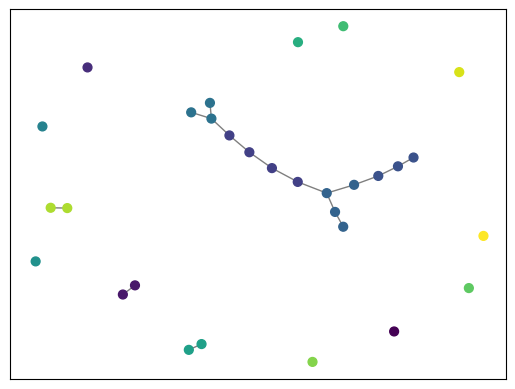

Community 3: 4 nodes
Community 1: 2 nodes
Community 2: 1 nodes
Community 4: 3 nodes
Community 5: 4 nodes
Community 6: 3 nodes
Community 7: 1 nodes
Community 8: 1 nodes
Community 9: 2 nodes
Community 10: 1 nodes
Community 11: 1 nodes
Community 12: 1 nodes
Community 13: 1 nodes
Community 14: 2 nodes
Community 16: 1 nodes
Community 0: 1 nodes
Community 15: 1 nodes
Modularity of the partition: 0.63


In [45]:
import community as community_louvain
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.erdos_renyi_graph(30, 0.05)

# Compute the best partition
partition = community_louvain.best_partition(G)

# Visualize the network with its community structure
pos = nx.spring_layout(G)
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# Analyze community structure
community_sizes = {}
for node, community in partition.items():
    if community not in community_sizes:
        community_sizes[community] = 0
    community_sizes[community] += 1

# Print the size of each community
for community, size in community_sizes.items():
    print(f"Community {community}: {size} nodes")

# Calculate and print the modularity
modularity = community_louvain.modularity(partition, G)
print(f"Modularity of the partition: {modularity:.2f}")

/var/folders/fm/308gqmvs3sg8818yyfypgfr80000gn/T/ipykernel_47318/1656800843.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


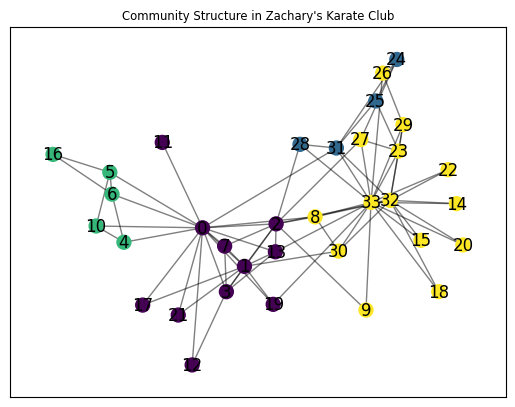

Node	Community
0	0
1	0
2	0
3	0
4	2
5	2
6	2
7	0
8	3
9	3
10	2
11	0
12	0
13	0
14	3
15	3
16	2
17	0
18	3
19	0
20	3
21	0
22	3
23	3
24	1
25	1
26	3
27	3
28	1
29	3
30	3
31	1
32	3
33	3
Modularity of the partition: 0.44


In [47]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# Load the Zachary's Karate Club graph
G = nx.karate_club_graph()

# Compute the best community partition using the Louvain method
partition = community_louvain.best_partition(G)

# Visualize the network
pos = nx.spring_layout(G)  # positions for all nodes
# Color the nodes according to their partition
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=100,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos)
plt.title('Community Structure in Zachary\'s Karate Club')
plt.show()

# Display the community to which each member belongs
print("Node\tCommunity")
for node, com in partition.items():
    print(f"{node}\t{com}")

# Calculate and print the modularity of the partition
modularity = community_louvain.modularity(partition, G)
print(f"Modularity of the partition: {modularity:.2f}")


In [53]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# Load the Dolphin social network
G = nx.read_gml('polblogs.gml')

# Compute the best community partition using the Louvain method
partition = community_louvain.best_partition(G)

# Visualize the network
pos = nx.spring_layout(G)  # positions for all nodes
# Color the nodes according to their partition
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, node_size=100,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Community Structure in Dolphin Social Network')
plt.show()

# Display the community to which each dolphin belongs
print("Dolphin\tCommunity")
for node, com in partition.items():
    print(f"{node}\t{com}")

# Calculate and print the modularity of the partition
modularity = community_louvain.modularity(partition, G)
print(f"Modularity of the partition: {modularity:.2f}")


NetworkXError: edge #12757 (1047->1179) is duplicated

In [57]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


/var/folders/fm/308gqmvs3sg8818yyfypgfr80000gn/T/ipykernel_47318/240470465.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(G, pos, node_color=labels, cmap=plt.cm.get_cmap('viridis', k))


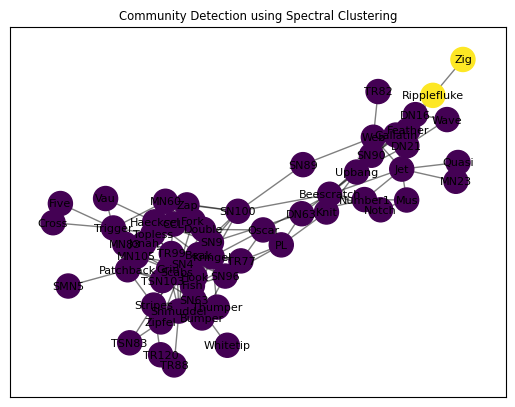

Eigenvalues: [0.1729733  0.57144632]


In [58]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.linalg import eigh

# Load the Dolphin social network
G = nx.read_gml('dolphins.gml')

# Compute the Laplacian matrix of the graph
L = nx.laplacian_matrix(G).toarray()

# Eigenvalue decomposition
eigenvalues, eigenvectors = eigh(L)

# Select the number of communities to detect (k)
k = 2

# Select the first k smallest non-zero eigenvectors (smallest eigenvalues)
# We skip the first eigenvector (corresponding to eigenvalue 0)
v = eigenvectors[:, 1:k+1]

# Clustering using k-means
kmeans = KMeans(n_clusters=k, random_state=42).fit(v)
labels = kmeans.labels_

# Visualize the network with community assignments
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=labels, cmap=plt.cm.get_cmap('viridis', k))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Community Detection using Spectral Clustering')
plt.show()

# Print eigenvalues for reference (optional)
print("Eigenvalues:", eigenvalues[1:k+1])


In [64]:
pip install numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [66]:
import numpy as np
import networkx as nx
from scipy.linalg import fractional_matrix_power

# Create the graph (example using networkx)
G = nx.read_gml('dolphins.gml')  # Load the Dolphin network if available or replace with appropriate graph loading method

# Adjacency matrix
A = nx.adjacency_matrix(G).toarray()

# Adding self-loops
A = A + np.eye(G.number_of_nodes())

# Degree matrix
D = np.diag(np.sum(A, axis=1))

# Compute D^-0.5
D_half_norm = fractional_matrix_power(D, -0.5)

# Feature matrix initialization (simple identity matrix in this example)
E = np.eye(G.number_of_nodes())
C = np.eye(G.number_of_nodes())  # This is just a placeholder, replace or modify as per actual features
X = np.concatenate((E, C), axis=1)

# Graph convolution operation
X = D_half_norm.dot(A).dot(D_half_norm).dot(X)

print(X)


[[0.14285714 0.         0.         ... 0.         0.         0.        ]
 [0.         0.11111111 0.         ... 0.         0.         0.        ]
 [0.         0.         0.2        ... 0.         0.         0.2236068 ]
 ...
 [0.         0.         0.         ... 0.16666667 0.         0.        ]
 [0.         0.         0.         ... 0.         0.5        0.        ]
 [0.         0.         0.2236068  ... 0.         0.         0.25      ]]
